# **TASK TWO**

## **Load Data**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")

print("Path to dataset files:", path)

100%|██████████| 522M/522M [00:14<00:00, 38.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
file_path = "/root/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2/stocks/ADT.csv"
df = pd.read_csv(file_path)
df.head()

data = df.copy()

In [4]:
df.describe()

,price
count,554.000000
mean,6.883286
std,1.429477
min,3.720000
25%,5.832438
50%,6.819164
75%,7.742966
max,11.385636


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       554 non-null    object 
 1   Open       554 non-null    float64
 2   High       554 non-null    float64
 3   Low        554 non-null    float64
 4   Close      554 non-null    float64
 5   Adj Close  554 non-null    float64
 6   Volume     554 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 30.4+ KB
None


In [9]:
# Check for missing values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [70]:
ticker = 'ADT'

In [11]:
def compute_rsi(data, window):
    """
    Compute the Relative Strength Index (RSI) for a given dataset.

    Args:
        data (pandas.Series): The price data.
        window (int): The lookback window for calculating RSI.

    Returns:
        pandas.Series: The RSI values.
    """
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [22]:
print(data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [45]:
data = data[['Date', 'Adj Close']].rename(columns={'Adj Close': 'price'})
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.tail()

,price
Date,
2020-03-26,4.66
2020-03-27,4.71
2020-03-30,4.34
2020-03-31,4.32
2020-04-01,4.09


## **Data Preparation**

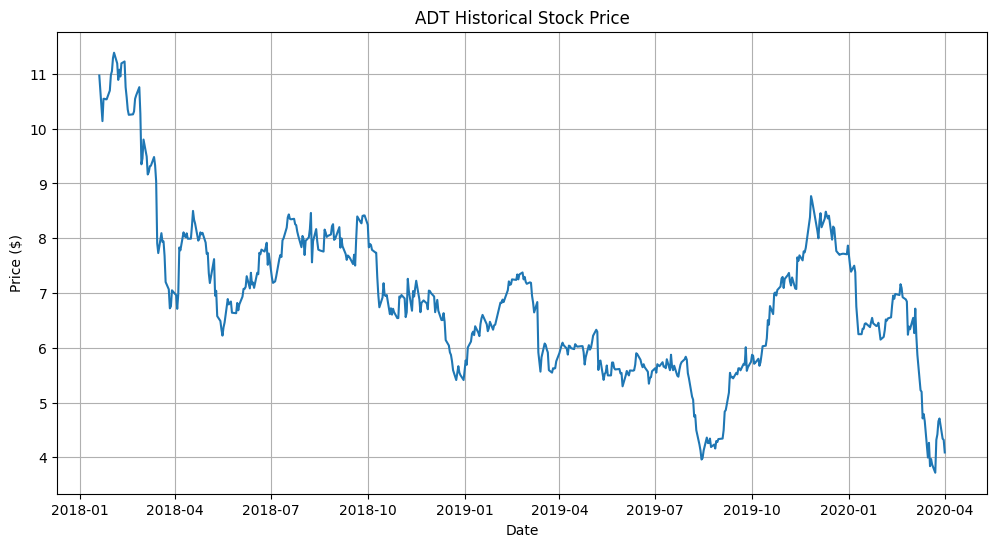

In [53]:
plt.figure(figsize=(12,6))
plt.plot(data['price'])
plt.title('ADT Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

## **Feature Engineering**

In [54]:
data['day'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year
data['day_of_week'] = data.index.dayofweek
print(data.head())

                price  day  month  year  day_of_week
Date                                                
2018-01-19  10.969521   19      1  2018            4
2018-01-22  10.137290   22      1  2018            0
2018-01-23  10.544551   23      1  2018            1
2018-01-24  10.544551   24      1  2018            2
2018-01-25  10.535697   25      1  2018            3


In [55]:
# Create technical indicators
data['sma_7'] = data['price'].rolling(window=7).mean()
data['sma_21'] = data['price'].rolling(window=21).mean()
data['rsi'] = compute_rsi(data['price'], 14)
data['daily_return'] = data['price'].pct_change()

# Lag features
for lag in [1, 2, 3, 5, 10]:
    data[f'lag_{lag}'] = data['price'].shift(lag)

# Drop NA values from feature creation
data = data.dropna()

In [63]:
data.head()

,price,day,month,year,day_of_week,sma_7,sma_21,rsi,daily_return,lag_1,lag_2,lag_3,lag_5,lag_10
Date,,,,,,,,,,,,,,
2018-02-16,10.252384,16,2,2018,4,10.757036,10.815216,41.935469,-0.009410,10.349773,10.571111,10.757036,11.190859,11.385636
2018-02-20,10.261238,20,2,2018,1,10.658382,10.781488,35.483897,0.000864,10.252384,10.349773,10.571111,11.226273,11.190859
2018-02-21,10.314360,21,2,2018,2,10.533168,10.789920,35.018082,0.005177,10.261238,10.252384,10.349773,10.757036,10.889839
2018-02-22,10.544551,22,2,2018,3,10.435779,10.789920,34.782631,0.022318,10.314360,10.261238,10.252384,10.571111,11.075764
2018-02-23,10.606524,23,2,2018,4,10.414277,10.792871,33.823511,0.005877,10.544551,10.314360,10.261238,10.349773,10.951813


## **Train-Test Split**

In [65]:
# Split chronologically
split_date = pd.to_datetime('2019-02-26')

train = data[data.index < split_date]
test = data[data.index >= split_date]

print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train.drop('price', axis=1))  # Features: day, month, year, day_of_week
X_test = scaler.transform(test.drop('price', axis=1))
y_train = train['price'].values
y_test = test['price'].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Training set size: 256
Testing set size: 278
X_train shape: (256, 13)
X_test shape: (278, 13)
y_train shape: (256,)
y_test shape: (278,)


## **Model Training**

### ***Deep Learning***

In [66]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Reshape data for LSTM [samples, timesteps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32,
                        validation_data=(X_test_lstm, y_test), verbose=1, shuffle=False)

# Predict
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 62.5059 - val_loss: 37.6078
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 61.3241 - val_loss: 36.6571
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 59.8035 - val_loss: 35.3440
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 57.5885 - val_loss: 33.4314
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 54.1648 - val_loss: 30.6217
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 49.1745 - val_loss: 26.6160
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 41.8806 - val_loss: 21.2926
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 32.8041 - val_loss: 15.0092
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 22.2556 - val_loss: 8.7845
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12.0490 - val_loss: 3.9798
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4318 - val_loss: 1.3498
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.1637 - val_loss: 0

### ***XGBoost***

In [67]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

## **Models Evaluation**

In [68]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f'{model_name} Evaluation:')
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

# Evaluate models
xgb_metrics = evaluate_model(y_test, xgb_pred, 'XGBoost')
lstm_metrics = evaluate_model(y_test, lstm_pred, 'LSTM')

XGBoost Evaluation:
MAE: 0.34
MSE: 0.36
RMSE: 0.60
MAPE: 7.09%
LSTM Evaluation:
MAE: 0.51
MSE: 0.36
RMSE: 0.60
MAPE: 8.61%


## **Visualization**

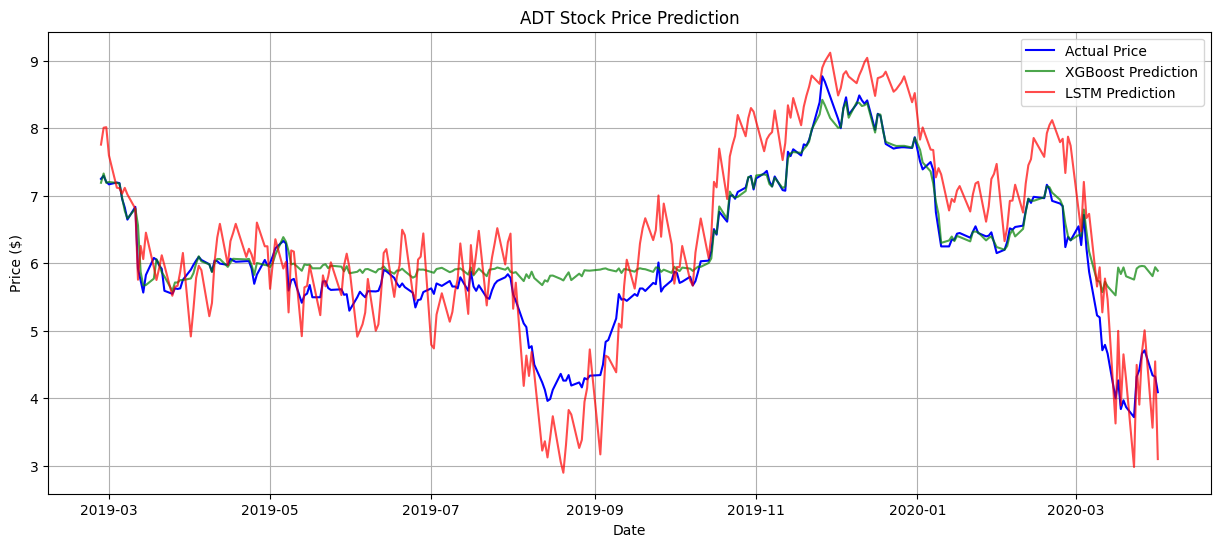

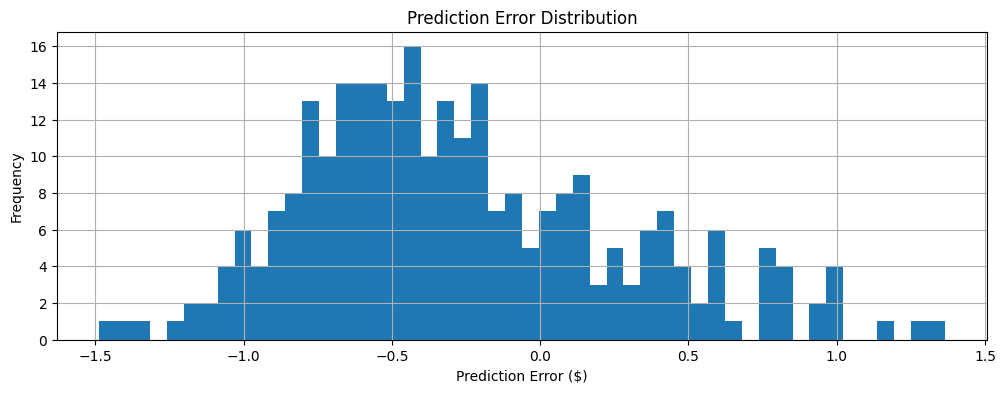

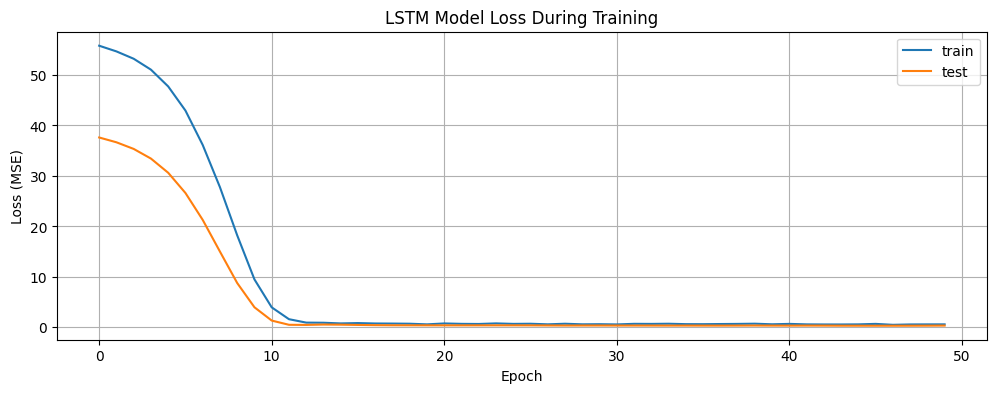

In [69]:
# Plot predictions vs actual
plt.figure(figsize=(15,6))
plt.plot(test.index, y_test, label='Actual Price', color='blue')
plt.plot(test.index, xgb_pred, label='XGBoost Prediction', color='green', alpha=0.7)
plt.plot(test.index, lstm_pred, label='LSTM Prediction', color='red', alpha=0.7)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot error distribution
errors = y_test - lstm_pred
plt.figure(figsize=(12,4))
plt.hist(errors, bins=50)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot training history for LSTM
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

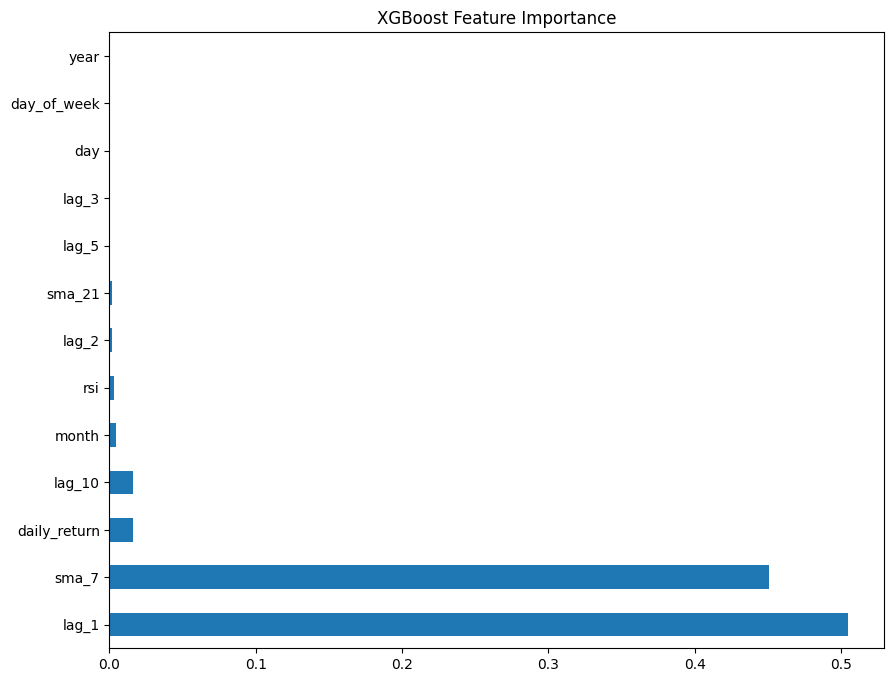

In [72]:
# Feature Importance for XGBoost
plt.figure(figsize=(10,8))
feat_importances = pd.Series(xgb_model.feature_importances_, index=train.drop('price', axis=1).columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.show()
